# INFO 3401 – Module Assignment 3

[Brian C. Keegan, Ph.D.](http://brianckeegan.com/)  
[Assistant Professor, Department of Information Science](https://www.colorado.edu/cmci/people/information-science/brian-c-keegan)  
University of Colorado Boulder  

Copyright and distributed under an [MIT License](https://opensource.org/licenses/MIT).

## Learning Objectives
This is one of two required sub-assignments for Module Assignment 3. In this assignment we want you to analyze time series data about a Wikipedia article. 


In [55]:
# Our usual libraries for working with data
import pandas as pd
import numpy as np

# Our usual libraries for visualizing data
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

# Some new libraries for retrieving data from the web, working with time, etc.
import requests, json
from datetime import datetime
from urllib.parse import unquote, quote
from copy import deepcopy

## Two functions to start

Below are two functions that I use in my research to retrieve data about Wikipedia articles. While Module 6 on "Structured Data" at the end of the term will go into more detail, you already have all the knowledge from INFO 1201 and 2201 to be able to interpret what these functions are doing. That said: you do not need to edit anything about these functions and can treat them like black boxes and you can skip down to "Step 0" if you're genuinely uncurious.

### Get the revision history for an article

Wikipedia keeps track of every single change made to every single article going back to approximately 2002. This is called a revision history: [this is the revision history for the "University of Colorado Boulder" article](https://en.wikipedia.org/w/index.php?title=University_of_Colorado_Boulder&action=history). You could get the content from previous versions of articles if you wanted from the API (again, check back in for Module 6) but this function simply retrieves the metadata about every revision: the ID of the revision, the ID of the user, if the user left a comment, the timestamp of the change, the username, the size of the page, and a SHA1 hash which is helpful for comparing if two versions of an article are identical.

I would **very** strongly caution you against trying to retrieve the complete revision histories for popular topics like "Donald Trump", "Hillary Clinton", etc. This function will work, but because these can have tens of thousands of revisions, it could take several minutes to retrieve them all.

In [56]:
def response_to_revisions(json_response):
    if type(json_response['query']['pages']) == dict:
        page_id = list(json_response['query']['pages'].keys())[0]
        return json_response['query']['pages'][page_id]['revisions']
    elif type(json_response['query']['pages']) == list:
        if 'revisions' in json_response['query']['pages'][0]:
            return json_response['query']['pages'][0]['revisions']
        else:
            return list()
    else:
        raise ValueError("There are no revisions in the JSON")

def get_all_page_revisions(page_title, endpoint='en.wikipedia.org/w/api.php', redirects=1):
    """Takes Wikipedia page title and returns a DataFrame of revisions
    
    page_title - a string with the title of the page on Wikipedia
    endpoint - a string that points to the web address of the API.
        This defaults to the English Wikipedia endpoint: 'en.wikipedia.org/w/api.php'
        Changing the two letter language code will return a different language edition
        The Wikia endpoints are slightly different, e.g. 'starwars.wikia.com/api.php'
    redirects - a Boolean value for whether to follow redirects to another page
        
    Returns:
    df - a pandas DataFrame where each row is a revision and columns correspond
         to meta-data such as parentid, revid, sha1, size, timestamp, and user name
    """
    
    # A container to store all the revisions
    revision_list = list()
    
    # Set up the query
    query_url = "https://{0}".format(endpoint)
    query_params = {}
    query_params['action'] = 'query'
    query_params['titles'] = page_title
    query_params['prop'] = 'revisions'
    query_params['rvprop'] = 'ids|userid|comment|timestamp|user|size|sha1'
    query_params['rvlimit'] = 500
    query_params['rvdir'] = 'newer'
    query_params['format'] = 'json'
    query_params['redirects'] = redirects
    query_params['formatversion'] = 2
    
    # Make the query
    json_response = requests.get(url = query_url, params = query_params).json()

    # Add the temporary list to the parent list
    revision_list += response_to_revisions(json_response)

    # Loop for the rest of the revisions
    while True:

        # Newer versions of the API return paginated results this way
        if 'continue' in json_response:
            query_continue_params = deepcopy(query_params)
            query_continue_params['rvcontinue'] = json_response['continue']['rvcontinue']
            json_response = requests.get(url = query_url, params = query_continue_params).json()
            revision_list += response_to_revisions(json_response)
        
        # Older versions of the API return paginated results this way
        elif 'query-continue' in json_response:
            query_continue_params = deepcopy(query_params)
            query_continue_params['rvstartid'] = json_response['query-continue']['revisions']['rvstartid']
            json_response = requests.get(url = query_url, params = query_continue_params).json()
            revision_list += response_to_revisions(json_response)
        
        # If there are no more revisions, stop
        else:
            break

    # Convert to a DataFrame
    df = pd.DataFrame(revision_list)

    # Add in some helpful fields to the DataFrame
    df['page'] = json_response['query']['pages'][0]['title']
    
    return df

### Get the pageviews for an article

Wikipedia also keeps track of all the times an article was accessed, ***but only back to July 2015***. [Here are the recent page views for the "University of Colorado Boulder" article](https://pageviews.toolforge.org/?project=en.wikipedia.org&platform=all-access&agent=user&redirects=0&range=latest-20&pages=University_of_Colorado_Boulder). Getting all five years of data will take several minutes, so please keep that in mind, but there's no penalty for getting the pageview data for a popular topics compared to a non-popular topic.

In [57]:
def get_pageviews(page_title,endpoint='en.wikipedia.org',date_from='20150701',date_to='today'):
    """Takes Wikipedia page title and returns a all the various pageview records
    
    page_title - a string with the title of the page on Wikipedia
    lang - a string (typically two letter ISO 639-1 code) for the language edition,
        defaults to "en"
        datefrom - a date string in a YYYYMMDD format, defaults to 20150701 (earliest date)
        dateto - a date string in a YYYYMMDD format, defaults to today
        
    Returns:
    s - a Series indexed by date with page views as values
    """
    if date_to == 'today':
        date_to = str(datetime.today().date()).replace('-','')
        
    quoted_page_title = quote(page_title, safe='')
    date_from = datetime.strftime(pd.to_datetime(date_from),'%Y%m%d')
    date_to = datetime.strftime(pd.to_datetime(date_to),'%Y%m%d')
    
    s = "https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/{1}/{2}/{3}/{0}/daily/{4}/{5}".format(quoted_page_title,endpoint,'all-access','user',date_from,date_to)
    json_response = requests.get(s).json()
    
    if 'items' in json_response:
        df = pd.DataFrame(json_response['items'])
    else:
        raise KeyError('There is no "items" key in the JSON response.')
        
    df = df[['timestamp','views']]
    df['timestamp'] = pd.to_datetime(df['timestamp'],format='%Y%m%d%H')
    s = df.set_index('timestamp')['views']
        
    return s

## Step 0: Write down a research question and motivation

Why are you choosing this article to analyze? What kinds of information production (revisions) and consumption (pageviews) behavior are you expecting to observe? For whom does this matter and why? Because of the limitations of the data, try to come up with questions/motivations/hypotheses for behavior in or after July 2015.

The Denver Nuggets just went on a huge run in the NBA playoffs. They unexpectedly made it all the way to the Western Conference Finals which we haven't done in a long time. Therefore, I want to see if there has been a huge increase in pageviews on the Nuggets wikipedia page due to their success. 

## Step 1: Retrieve the revision history for a single article

### Step 1a: Use the `get_all_page_revisions` function on your article

In [58]:
# cub_rev_df = get_all_page_revisions('University of Colorado Boulder')

In [59]:
den_rev_df = get_all_page_revisions('Denver Nuggets')

### Step 1b: Inspect the top and print out the number of revisions

In [60]:
den_rev_df.head()

,revid,parentid,user,userid,timestamp,size,sha1,comment,anon,page
0,392365,0,Zoe,2376,2002-08-17T21:18:29Z,783,8f1d8e346406ff0d7eff15876cf28fb52d5246c8,,NaN,Denver Nuggets
1,997145,392365,65.239.11.248,0,2002-10-29T13:49:12Z,794,6e729b117838cb28e928aa8914d9f7172a965d8e,,True,Denver Nuggets
2,1211921,997145,Smith03,12429,2003-06-04T17:05:15Z,818,b4f44e711dc5d4b9989f39398b18392c351c8efc,,NaN,Denver Nuggets
3,1211926,1211921,JustJamie820,10200,2003-07-29T03:40:04Z,800,7b0b0224243e959d62a0bb9ca2d4b8b3879daad4,"The Denver Nuggets have new colours, updated e...",NaN,Denver Nuggets
4,1211962,1211926,Hephaestos,3628,2003-07-29T03:42:05Z,844,5094d06260906f7a4578753bfb0793a5e04005ba,,NaN,Denver Nuggets


In [61]:
den_rev_df.shape

(3349, 10)

### Step 1c: When was the first revision made? The most recent?

In [62]:
den_rev_df.tail()

,revid,parentid,user,userid,timestamp,size,sha1,comment,anon,page
3344,982011847,981645859,98.198.4.102,0,2020-10-05T17:57:31Z,85279,92f47e1b06c407d18ba843ccf98751a111afee7b,,True,Denver Nuggets
3345,982012952,982011847,Materialscientist,7852030,2020-10-05T18:04:38Z,85278,961db7502378fa3dd0f7bc60ec9ed419134605e0,Reverted edits by [[Special:Contributions/98.1...,NaN,Denver Nuggets
3346,982244779,982012952,Mandarax,191757,2020-10-07T00:11:22Z,85278,ccc34527938999869f6aecd1343a35b1d6ac1528,Correct capitalization,NaN,Denver Nuggets
3347,982449021,982244779,188.120.116.151,0,2020-10-08T06:28:46Z,85268,063efad205498ef67f658b5df1d06d65e747da89,/* 2015–present : Jokić era */,True,Denver Nuggets
3348,983068372,982449021,Dylpickle2k,40320890,2020-10-12T01:49:29Z,85191,539a499845d337c1d41625b42334eab738737e27,/* 2015–present : Jokić era */Fixed grammar an...,NaN,Denver Nuggets


In [63]:
print("The first revision was made {}".format(den_rev_df.loc[0]["timestamp"]))

The first revision was made 2002-08-17T21:18:29Z


In [64]:
last = len(den_rev_df.index) - 1
print("The most recent revision was made {}".format(den_rev_df.loc[last]["timestamp"]))

The most recent revision was made 2020-10-12T01:49:29Z


### Step 1d: What "user" made the most revisions to this article?

In [65]:
den_rev_df["user"].value_counts().head(1)

MarnetteD    214
Name: user, dtype: int64

## Step 2: Engineer new temporal features

We want to make several new columns that capture temporal behavior.

### Step 2a: Convert the "timestamp" column from `str` to `pd.Timestamp`

In [66]:
den_rev_df["timestamp"] = pd.to_datetime(den_rev_df["timestamp"])

In [67]:
den_rev_df.loc[0,"timestamp"].date()

datetime.date(2002, 8, 17)

### Step 2b: Create a column "date" that has only the dates of the revision

In [68]:
den_rev_df["date"] = den_rev_df["timestamp"].apply(lambda x:x.date())

### Step 2c: Create a column "weekday" that has the day of the week of the revision

In [69]:
den_rev_df["weekday"] = den_rev_df["timestamp"].apply(lambda x:x.weekday())

### Step 2d: Create a column "hour" that has the hour of the revision

In [70]:
den_rev_df["hour"] = den_rev_df["timestamp"].apply(lambda x:x.hour)

### Step 2e: Create a column "diff" that is the change in the "size" since the last revision

This is not a temporal variable but it will require you to use a method we discussed in the pre-class lectures.

In [71]:
den_rev_df["diff"] = den_rev_df["size"] - den_rev_df["size"].shift(1)

### Step 2f: Create a column "lag" that has the time elapsed since the previous edit

Make sure this is stored as a float or an integer of a reasonable unit (minutes, hours, days, weeks, etc.) and **not as a Timedelta**.

In [72]:
den_rev_df["lag"] = den_rev_df["date"] - den_rev_df["date"].shift(1)
den_rev_df["lag"] = den_rev_df["lag"].dt.days
# documentation for .dt.days method: https://stackoverflow.com/questions/25646200/python-convert-timedelta-to-int-in-a-dataframe
den_rev_df.loc[1,"lag"]

73.0

### Step 2g: Create a column "age" that has the time elapsed since the first edit

Make sure this is stored as a float or an integer of a reasonable unit (minutes, hours, days, weeks, etc.) and **not as a Timedelta**.

In [73]:
den_rev_df["age"] = den_rev_df["date"] - den_rev_df["date"].loc[0]
den_rev_df.head()

,revid,parentid,user,userid,timestamp,size,sha1,comment,anon,page,date,weekday,hour,diff,lag,age
0,392365,0,Zoe,2376,2002-08-17 21:18:29+00:00,783,8f1d8e346406ff0d7eff15876cf28fb52d5246c8,,NaN,Denver Nuggets,2002-08-17,5,21,NaN,NaN,0 days
1,997145,392365,65.239.11.248,0,2002-10-29 13:49:12+00:00,794,6e729b117838cb28e928aa8914d9f7172a965d8e,,True,Denver Nuggets,2002-10-29,1,13,11.0,73.0,73 days
2,1211921,997145,Smith03,12429,2003-06-04 17:05:15+00:00,818,b4f44e711dc5d4b9989f39398b18392c351c8efc,,NaN,Denver Nuggets,2003-06-04,2,17,24.0,218.0,291 days
3,1211926,1211921,JustJamie820,10200,2003-07-29 03:40:04+00:00,800,7b0b0224243e959d62a0bb9ca2d4b8b3879daad4,"The Denver Nuggets have new colours, updated e...",NaN,Denver Nuggets,2003-07-29,1,3,-18.0,55.0,346 days
4,1211962,1211926,Hephaestos,3628,2003-07-29 03:42:05+00:00,844,5094d06260906f7a4578753bfb0793a5e04005ba,,NaN,Denver Nuggets,2003-07-29,1,3,44.0,0.0,346 days


## Step 3: Visualize the revision data

### Step 3a: Use the "hour" and "weekday" columns to make a revision heatmap

Use your data reshaping skills like `pivot_table` and read up on how to make a [heatmap in Seaborn](https://seaborn.pydata.org/generated/seaborn.heatmap.html) ([also](https://towardsdatascience.com/heatmap-basics-with-pythons-seaborn-fb92ea280a6c)) showing when revisions on your article tend to happen. Your revision heatmap should have "weekday" as columns and "hour" as an index and a count of revisions as values.

<AxesSubplot:xlabel='weekday', ylabel='hour'>

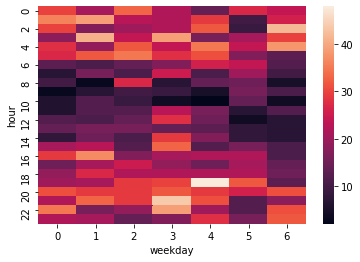

In [74]:
rev_pivot = pd.pivot_table(den_rev_df,
                           index="hour",
                           columns="weekday",
                           values= "user",
                           aggfunc='count'
                                )
sb.heatmap(rev_pivot)

### Step 3b: Interpret and summarize some interesting features about the revision heatmap

During what part of the day and week are most revisions to this article made? Is this surprising or expected? What kinds of mechanisms social conventions for time could explain why there is or is not a clear pattern? If you had to tell someone to give you a report on the state of the article every week, when should they look at the article?

The most popular time for revisions was Friday night at 6:00. Perhaps this was when one person would do their weekly update of the page. Otherwise, the most popular times are during the evening from 5 to 4 in the morning. It is very interesting that the revisions are so popular so early in the morning/late at night. I anticipate that this is much different than most Wikipedia articles. This behavioral nature is most likely due to the fact that basketball teams play nightly games so their pages can be updated every night when the game finishes.

### Step 3c: Make a line plot of the number of revisions over time

Use pandas's groupby, reindex, and/or resample functionality to count the number of revisions by day. Make sure that the date range is continuous without gaps and dates without revision activity have an appropriate value. Plot the data.

<AxesSubplot:xlabel='timestamp'>

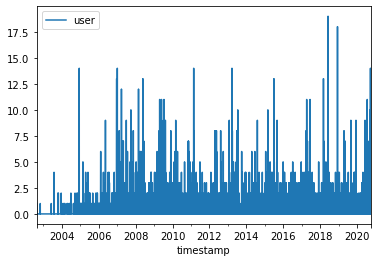

In [75]:
gb_date = den_rev_df.groupby(pd.Grouper(key="timestamp",freq="D")).agg({"user":"count"})
gb_date.plot()

### Step 3d: Interpret and summarize some interesting features about the revision activity line plot

Are there any trends of increasing or decreasing revision activity? Are there any instances of "bursts" of revision activity? If so, do these bursts correspond to meaningful events in the "real" world?

There seem to be a lot of bursts every year. I anticipate that this is from when the Nuggets get a new player, their season recently finishes, or they get a new head coach. These are common things that would require an update to the wikipedia page. It is hard to say exactly what the bursts were from because there are so many. This data does surprise though because there is a constant stream of updates everyday, even during the offseason. I expected a much more cyclical looking graph. However, on this graph it is hard to even determine when the offseason is.

### Step 3e: Make a scatter plot of "lag" and "diff"

Make a scatterplot with the "lag" column on the x-axis and the "diff" column on the y-axis.

<AxesSubplot:xlabel='lag', ylabel='diff'>

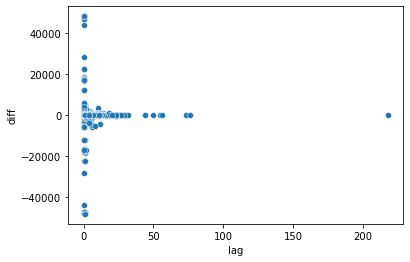

In [76]:
sb.scatterplot(data=den_rev_df, x="lag",y="diff")

### Step 3f: Interpret and summarize some interesting features about the lag-diff scatter plot

Why are the diff values so abnormally large? Let's investigate

In [77]:
den_rev_df["diff"].sort_values()

3006   -48296.0
3002   -48283.0
3014   -48269.0
1797   -47192.0
1795   -47175.0
         ...   
1798    47192.0
3015    48269.0
3003    48283.0
3007    48296.0
0           NaN
Name: diff, Length: 3349, dtype: float64

Here we can see that what probably occured was a few users who would completely delete everything on the wikipedia page and then someone quickly coming in and fixing the information.

## Step 4: Retrieve the pageviews for a single article

### Step 4a: Use the `get_pageviews` function on your article

In [96]:
den_pv_df = get_pageviews('Denver Nuggets')
den_pv_df = den_pv_df.to_frame()

In [97]:
pv_date_range = pd.date_range(start="2015-07-01",
                             end="2020-10-01",
                             freq="D")
den_pv_df

,views
timestamp,
2015-07-01,1268
2015-07-02,1250
2015-07-03,1252
2015-07-04,1165
2015-07-05,1151
...,...
2020-10-07,1296
2020-10-08,884
2020-10-09,813


### Step 4b: Inspect the top and print out the number of pageview observations

In [98]:
den_pv_df.head()

,views
timestamp,
2015-07-01,1268
2015-07-02,1250
2015-07-03,1252
2015-07-04,1165
2015-07-05,1151


In [99]:
den_pv_df.shape

(1930, 1)

In [100]:
den_pv_df.sum()

views    2609715
dtype: int64

### Step 4c: Make sure the time variables are `Timestamp`s

In [101]:
den_pv_df.index = pd.to_datetime(den_pv_df.index)

### Step 4d: What date had the most pageviews? The fewest?

In [106]:
# fewest pageviews
den_pv_df.sort_values("views").head(1)

,views
timestamp,
2015-08-29,557


In [107]:
# most pageviews
den_pv_df.sort_values("views",ascending=False).head(1)

,views
timestamp,
2020-09-16,44871


## Step 5: Visualize pageview data

### Step 5a: Make a line plot of the number of pageviews over time

<AxesSubplot:xlabel='timestamp'>

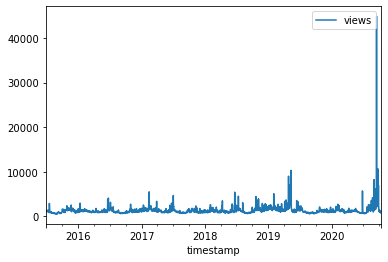

In [108]:
den_pv_df.plot()

<AxesSubplot:xlabel='timestamp'>

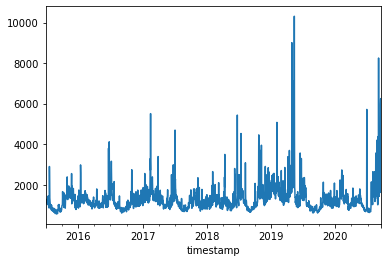

In [161]:
# that plot isn't super helpful besides showing how massive of a burst September 16th, 2020 was 
# so let's zoom in
den_pv_df[:"2020-09-15"]["views"].plot()

### Step 5b: Make a barplot of the pageview activity by day of week

In [112]:
den_pv_df["weekday"] = [i.weekday() for i in den_pv_df.index]

<AxesSubplot:xlabel='weekday'>

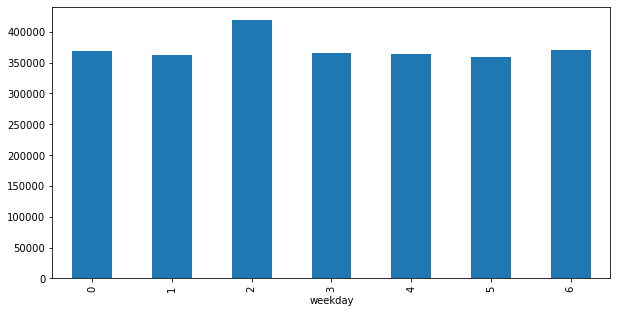

In [121]:
#consulted outside documentation: https://medium.com/@danalindquist/https-medium-com-danalindquist-bar-chart-of-weekly-data-count-using-pandas-5c95a536a08e

day_of_week = den_pv_df.groupby("weekday")["views"].sum()
day_of_week.plot(kind='bar',figsize=(10,5),legend=None)

### Step 5c: Make an autocorrelation plot of the pageview data

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

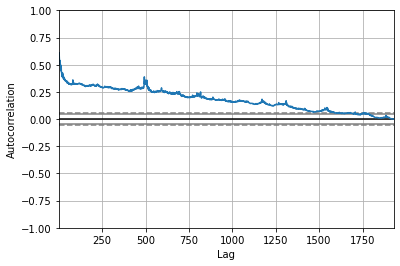

In [122]:
pd.plotting.autocorrelation_plot(den_pv_df)

### Step 5d: Interpret and summarize some interesting features about the pageview behavior

I thought it was interesting that Wednesday was the most popular day of the week to view the Nuggets page. I did some research and found out that the most popular day of viewing on September 16, 2020 (when the page got almost 45,000 views) was a Wednesday, which obviously contributes to this discrepancy. Furthermore, I was surprised by how high the autocorrelation is. Additionally, I was surprised by how unseasonal the pageview data was. When plotting the pageviews over time, I expected to see massive decreases in activity during the offseason but they were much more minimal than I thought.

## Step 6: Combing revision and pageview data

### Step 6a: Make a DataFrame containing only daily revision and pageviews

In [154]:
# I worked for a long time to do this step cleanly, but eventually had to settle for combining the data
# this way

revisions = gb_date.loc["2015-07-01":"2020-10-11"] # had to manually put an end date because it was
                                                    # too long for my pageview data
len([i for i in revisions["user"]])

1930

In [153]:
den_pv_df["views"]

timestamp
2015-07-01    1268
2015-07-02    1250
2015-07-03    1252
2015-07-04    1165
2015-07-05    1151
              ... 
2020-10-07    1296
2020-10-08     884
2020-10-09     813
2020-10-10    1025
2020-10-11     867
Name: views, Length: 1930, dtype: int64

In [163]:
combined_df = den_pv_df["views"]
combined_df = combined_df.to_frame()
combined_df["revisions"] = [i for i in revisions["user"]]
combined_df.head()

,views,revisions
timestamp,,
2015-07-01,1268,13
2015-07-02,1250,1
2015-07-03,1252,8
2015-07-04,1165,0
2015-07-05,1151,2


### Step 6b: Plot both these time series on the same figure

Use good visualization practices to ensure that a reader can identify meaningful variability in both. See using [Scales](https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html#scales), [Plotting on a secondary y-axis](https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html#plotting-on-a-secondary-y-axis), or [Subplots](https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html#subplots) for ideas.

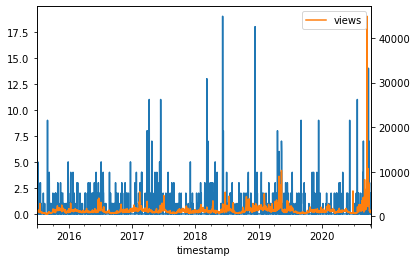

In [158]:
combined_df["revisions"].plot()
combined_df["views"].plot(secondary_y=True)
plt.legend()

<AxesSubplot:xlabel='timestamp'>

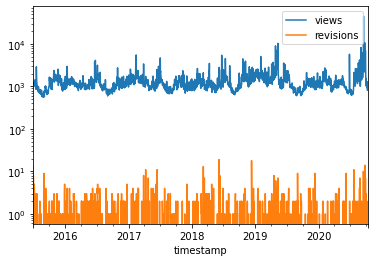

In [159]:
combined_df.plot(logy=True)

### Step 6c: Interpret and summarize some interesting features about revision and pageview behavior

As expected, there tends to be a increase in revisions at the same time as there is an increase in pageviews. This makes logical sense because whenever a big event happens for the franchise, people will want to update the page and view the page. However, just because there is a massive increase in views does not necessarily mean there will be a massive increase in revisions. There is only so much data to be updated. For example, on September 16th, 2020 there were almost 45,000 pageviews but only 9 revisions.

### Step 6d: Revisit your research question/hypotheses/motivation and discuss in light of your findings

My research hypothesis proved to be correct in that there was a massive surge in the Denver Nuggets page over the course of this playoff run. This proved to be especially true on September 16th when the Nuggets defeated the Los Angeles Clippers in a game 7 to advance Denver to the Western Confernece Finals. This was a big upset which as a result garnered a lot of attention as evident in the pageview data. Other than this specific day though there was not too big of an increase in pageview data over the playoff run. I expected a general incline in pageviews during August and September but there really wasn't that large of an increase. I suppose that big increases in Wikipedia pageviews tend to come from large one-time events as opposed to over time repeated "success". 

In the future I would want to use some of the forecasting tools we have learned in class on this data to see what the models predict future pageview data would look like.